In [1]:
import geopandas as gpd

import lxml
from lxml import etree
import pysal as ps
import pandas as pd
import numpy as np
import seaborn as sns
# from pysal.contrib.viz import mapping as maps
%matplotlib inline
import matplotlib.pyplot as plt
import gzip

# Add basemap utility

# import contextily as ctx

# def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
#     xmin, xmax, ymin, ymax = ax.axis()
#     basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
#     ax.imshow(basemap, extent=extent, interpolation='bilinear')
#     # restore original x/y limits
#     ax.axis((xmin, xmax, ymin, ymax))

/Users/sfeygi/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
def open_xml(path):
    # Open xml and xml.gz files into ElementTree
    if path.endswith('.gz'):
        return etree.parse(gzip.open(path))
    else:
        return etree.parse(path)

    


In [3]:
# Parse activities
tree = open_xml("/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/sample/15k/population.xml")
root = tree.getroot()
acts = []
for person in root.findall("./person"):
    pid = person.get('id')
    attributes,plan = person.getchildren()
    
    age=int(attributes.findall('./attribute[@name="age"]')[0].text)
    sex = attributes.findall('./attribute[@name="sex"]')[0].text
    activities = plan.getchildren()
    for activity in activities:
        act_type = activity.get('type')
        act_x = activity.get('x')
        act_y = activity.get('y')
        acts.append([pid,age,sex,act_type,act_x,act_y])
        
cols = ['pid','age','sex','type','x','y']
activity_df = pd.DataFrame(acts,columns=cols)
activity_df.set_index('pid',inplace=True)

In [4]:
# Parse population attributes and join with activities
tree = open_xml("/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/sample/15k/populationAttributes.xml.gz")
root = tree.getroot()
net = []
pop=root.getchildren()
for person in pop: 
    pid = person.get('id')
    attributes = person.findall("./attribute")
    res = {}
    res['pid'] = pid
    for attribute in attributes:
        res[attribute.attrib['name']] = attribute.text
    net.append(res)
pa_df = pd.DataFrame(net)
pa_df.set_index('pid',inplace=True)
pdf=pa_df.join(activity_df)

In [7]:
# Parse households
tree = open_xml("/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/sample/15k/households.xml")
root = tree.getroot()
households = []
hh_pid_keys = []
for household in root.findall('./{http://www.matsim.org/files/dtd}household'):
    tmp = []
    hh_pid_key = []
    hid = household.get('id')
    tmp.append(hid)
    members = household.findall('./{http://www.matsim.org/files/dtd}members/')
    vehicles = household.findall('./{http://www.matsim.org/files/dtd}vehicles/')
    income = household.findall('./{http://www.matsim.org/files/dtd}income')[0]
    for member in members:
        hh_pid_key.append([hid,member.get('refId')])
    tmp.append(','.join([member.get('refId') for member in members]))

    tmp.append(','.join([vehicle.get('refId') for vehicle in vehicles]))
       
    tmp.append(float(income.text.strip("\t\n")))
    households.append(tmp)
    hh_pid_keys.extend(hh_pid_key)
cols = ['hid','pids','vids','hh_income']
hdf = pd.DataFrame(households,columns=cols)
hdf.set_index('hid',inplace=True)

cols = ['hid','pid']
hh_p_df = pd.DataFrame(hh_pid_keys,columns=cols)
hh_p_df.set_index('hid',inplace=True)

In [8]:
merged = pd.merge(hdf,hh_p_df,left_index=True,right_index=True)
merged = merged.set_index('pid',append=True).reset_index().set_index('pid')
merged = merged.join(activity_df).drop(['pids','vids'],axis=1)

In [9]:
# Create population point shapefile

from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(pdf.x.astype(float), pdf.y.astype(float))]
pdf = pdf.drop(['x', 'y'], axis=1)
crs = {'init': 'epsg:26914'}
pt_gdf = gpd.GeoDataFrame(pdf, crs=crs, geometry=geometry)


In [12]:
# Load links gdf
links_gdf=gpd.read_file("/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/shape/links.shp")

shp_poly = "/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/shape/sioux_falls_population_counts_by_census_block_dissolved.shp"

sf_gdf = gpd.read_file(shp_poly)
sf_gdf.crs={'init': 'epsg:4326'}
data = ps.pdio.read_files(shp_link)

/Users/sfeygi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


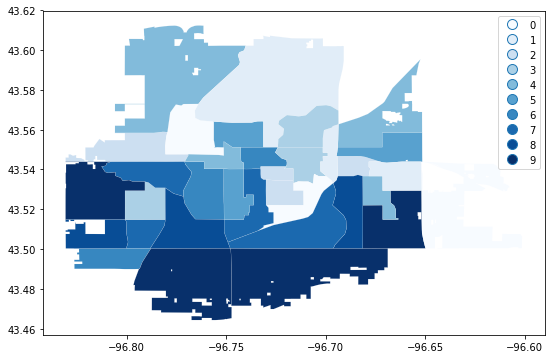

In [13]:
hr10 = ps.Quantiles(data.pop_pct, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
sf_gdf.assign(cl=hr10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='Blues', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)


In [14]:
joined_gdf=gpd.sjoin(sf_gdf.to_crs(epsg=26914),pt_gdf[pt_gdf['type']=='Home'],op='contains')
joined_gdf.income = joined_gdf.income.astype(float)

/Users/sfeygi/anaconda3/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [15]:
means = joined_gdf.groupby('tract').mean()
sub_sf_gdf=sf_gdf[sf_gdf.tract.isin(means.index)]

/Users/sfeygi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


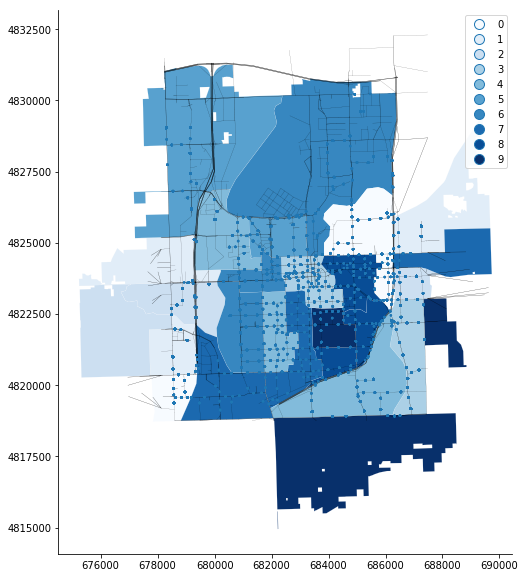

In [16]:
means = joined_gdf.groupby('tract').mean()
hr10 = ps.Quantiles(means.age, k=10)
f, ax = plt.subplots(1, figsize=(10, 10))

sub_sf_gdf.to_crs(epsg=26914).assign(cl=hr10.yb).set_index('tract').join(means,lsuffix='l').plot(column='cl',categorical=True, \
        k=10, cmap='Blues', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax=links_gdf.plot(ax=ax,color='k',linewidth=1)
pt_gdf[pt_gdf['type']=='Home'].plot(column='type',ax=ax,markersize=2.0)
sns.despine()